<a href="https://colab.research.google.com/github/manojmukkamala/VolcanoesOnVenus/blob/master/VenusModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Set-Up

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *

%matplotlib inline

### Importing the Dataset

In [0]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/venusvolcanoes.csv")

In [0]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071,12072,12073,12074,12075,12076,12077,12078,12079,12080,12081,12082,12083,12084,12085,12086,12087,12088,12089,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099,Volcano,trn_tst
0,95,101,99,103,95,86,96,89,70,104,115,96,89,102,109,108,102,104,95,91,100,99,97,100,107,109,98,98,94,98,102,87,82,94,105,93,102,107,98,105,...,105,103,74,88,106,111,90,96,101,90,97,102,97,106,108,107,93,74,106,115,107,102,91,103,111,105,116,117,111,107,92,89,103,99,117,116,118,96,1,train
1,91,92,91,89,92,93,96,101,107,104,92,81,76,83,88,93,91,92,93,90,83,81,79,84,86,87,92,93,94,94,87,83,95,96,94,91,93,96,93,87,...,91,89,88,90,88,93,95,106,113,116,108,94,92,96,99,92,87,89,105,119,121,116,111,113,112,103,101,103,103,92,93,95,98,105,104,100,90,81,0,train
2,87,70,72,74,84,78,93,104,106,106,94,79,96,88,86,89,98,94,76,78,91,96,86,71,82,76,72,81,90,84,81,70,75,91,81,81,92,94,79,97,...,83,93,94,91,90,94,96,78,88,95,121,108,88,87,89,100,99,88,107,108,101,88,95,81,57,84,89,92,84,71,95,102,94,80,91,80,84,90,0,train
3,114,118,124,119,95,118,105,116,123,112,110,113,119,112,105,121,117,125,136,141,120,120,129,135,132,124,109,126,113,110,106,107,113,116,123,101,99,89,81,101,...,114,103,114,109,113,126,110,84,92,111,114,125,122,109,113,111,121,119,103,114,118,118,108,111,109,100,101,105,116,113,102,93,109,104,106,117,111,115,0,train
4,79,95,90,82,73,74,77,75,82,87,84,81,83,69,72,84,93,84,89,83,86,89,95,94,82,80,96,96,89,86,93,88,82,70,76,84,82,59,81,101,...,73,91,94,90,81,80,70,71,73,84,87,89,97,99,92,77,87,96,75,78,92,72,83,86,95,87,78,90,90,80,79,78,65,71,62,97,89,73,0,train


In [0]:
X_train = df[df["trn_tst"] == "train"].drop(columns = ["Volcano", "trn_tst"])
X_test = df[df["trn_tst"] == "test"].drop(columns = ["Volcano", "trn_tst"])
y_train = df[df["trn_tst"] == "train"]["Volcano"]
y_test = df[df["trn_tst"] == "test"]["Volcano"]

#### Data

In [0]:
print("Number of Input Examples:", X_train.shape[0])
print("Number of Input Features:", X_train.shape[1], '\n')
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Number of Input Examples: 6747
Number of Input Features: 12100 

X_train shape: (6747, 12100)
y_train shape: (6747,)
X_test shape: (2631, 12100)
y_test shape: (2631,)


In [0]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12060,12061,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071,12072,12073,12074,12075,12076,12077,12078,12079,12080,12081,12082,12083,12084,12085,12086,12087,12088,12089,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
0,95,101,99,103,95,86,96,89,70,104,115,96,89,102,109,108,102,104,95,91,100,99,97,100,107,109,98,98,94,98,102,87,82,94,105,93,102,107,98,105,...,101,95,105,103,74,88,106,111,90,96,101,90,97,102,97,106,108,107,93,74,106,115,107,102,91,103,111,105,116,117,111,107,92,89,103,99,117,116,118,96
1,91,92,91,89,92,93,96,101,107,104,92,81,76,83,88,93,91,92,93,90,83,81,79,84,86,87,92,93,94,94,87,83,95,96,94,91,93,96,93,87,...,95,91,91,89,88,90,88,93,95,106,113,116,108,94,92,96,99,92,87,89,105,119,121,116,111,113,112,103,101,103,103,92,93,95,98,105,104,100,90,81
2,87,70,72,74,84,78,93,104,106,106,94,79,96,88,86,89,98,94,76,78,91,96,86,71,82,76,72,81,90,84,81,70,75,91,81,81,92,94,79,97,...,86,80,83,93,94,91,90,94,96,78,88,95,121,108,88,87,89,100,99,88,107,108,101,88,95,81,57,84,89,92,84,71,95,102,94,80,91,80,84,90
3,114,118,124,119,95,118,105,116,123,112,110,113,119,112,105,121,117,125,136,141,120,120,129,135,132,124,109,126,113,110,106,107,113,116,123,101,99,89,81,101,...,105,116,114,103,114,109,113,126,110,84,92,111,114,125,122,109,113,111,121,119,103,114,118,118,108,111,109,100,101,105,116,113,102,93,109,104,106,117,111,115
4,79,95,90,82,73,74,77,75,82,87,84,81,83,69,72,84,93,84,89,83,86,89,95,94,82,80,96,96,89,86,93,88,82,70,76,84,82,59,81,101,...,94,78,73,91,94,90,81,80,70,71,73,84,87,89,97,99,92,77,87,96,75,78,92,72,83,86,95,87,78,90,90,80,79,78,65,71,62,97,89,73


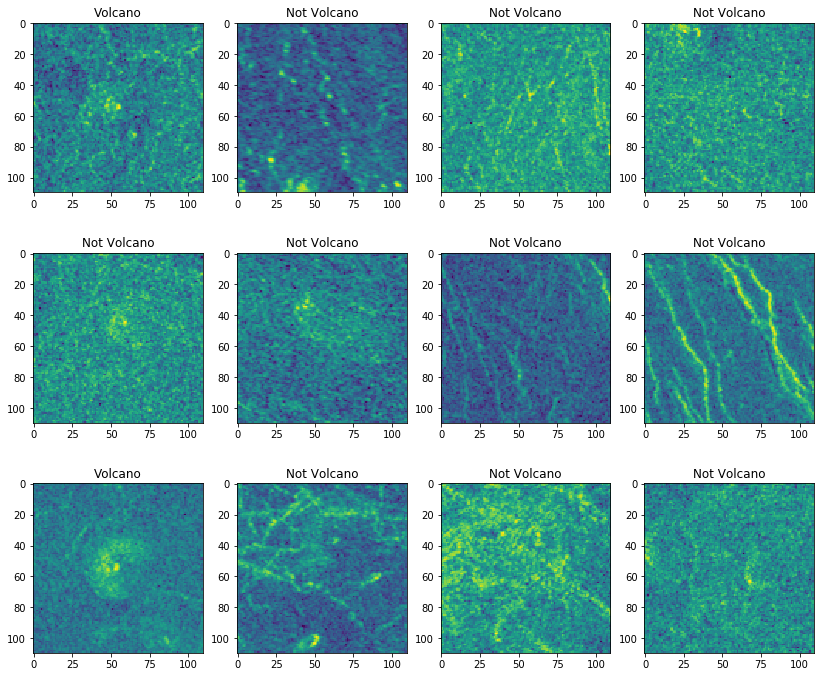

In [0]:
plt.figure(figsize = (14, 12))

for i in range(0, 12):
    subplot(3, 4, i+1)
    plt.imshow(np.array(X_train.iloc[i]).reshape(110, 110))
    plt.title("Volcano" if y_train[i] == 1 else "Not Volcano")

#### Target Classes

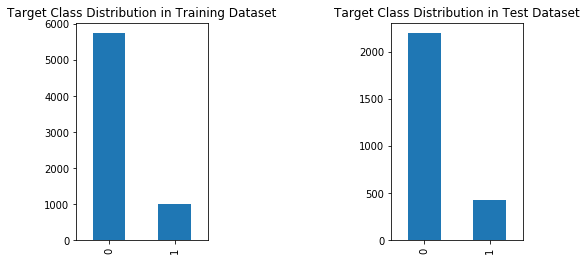

In [0]:
plt.figure(figsize = (8, 4))

subplot(1, 3, 1)
y_train.value_counts().plot.bar()
plt.title("Target Class Distribution in Training Dataset")

subplot(1, 3, 3)
y_test.value_counts().plot.bar()
plt.title("Target Class Distribution in Test Dataset")

plt.show()

### Data Preparation

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_test, y_test, test_size = 0.4, random_state = 42)

X_train = X_train.append(X_train2, ignore_index=True)
y_train = y_train.append(y_train2, ignore_index=True)

X_test, X_val, y_test, y_val = train_test_split(X_test2, y_test2, test_size = 0.5, random_state = 42)

del([X_train2, X_test2, y_train2, y_test2])

In [0]:
print("Training Samples:", X_train.shape[0])
print("Validation Samples:", X_val.shape[0])
print("Test Samples:", X_test.shape[0])

Training Samples: 8325
Validation Samples: 527
Test Samples: 526


#### Normalize

It is a good practice to normalize data before feeding it to the learning algorithm. Algorithms like gradient decent will converge faster if we normalize/standardize the input data.

In [0]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

In [0]:
X_train = np.array(X_train).T
X_test = np.array(X_test).T
X_val = np.array(X_val).T

In [0]:
y_train = np.array(y_train).T
y_test = np.array(y_test).T
y_val = np.array(y_val).T

## Models

### Helper Functions

In [0]:
def sigmoid(z):
    
    s = 1.0/(1.0 + np.exp(-z))
    
    return s

In [0]:
def relu(z):
    
    r = np.maximum(0, z)
    
    return r

In [0]:
def sigmoid_backward(X, Y, A):

  m = X.shape[1]

  dw = (1.0/m) * np.dot(X, (A - Y).T) 
  db = (1.0/m) * np.sum(A - Y)

  return dw, db

In [0]:
def relu_backward(X, Y, A, Z):
  
  m = X.shape[1]

  dA = - (np.divide(Y, A) - np.divide(1 - Y, 1 - A))

  dZ = np.array(dA, copy = True)

  dZ[Z <= 0] = 0

  dw = (1.0/m) * np.dot(X, dZ.T)
  db = (1.0/m) * np.sum(dZ)

  return dw, db

### Logistic Regression

In [0]:
def initialize_with_zeros(dim):
    
    w = np.zeros(shape = (dim, 1))
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [0]:
def propagate(w, b, X, Y, activation):
    
    m = X.shape[1]
    
    Z = np.dot(w.T, X) + b

    if activation == "sigmoid":
      A = sigmoid(Z)
      cost = (-1.0/m) * np.sum(np.multiply(Y, np.log(A)) + np.multiply((1-Y), np.log(1 - A)))
      dw, db = sigmoid_backward(X, Y, A)

    elif activation == "relu":
      A = relu(Z)
      #cost = (-1.0/m) * np.sum(np.multiply(Y, np.log(A)) + np.multiply((1-Y), np.log(1 - A)))
      cost = (1.0/m) * np.sum(np.square(A - Y))
      dw, db = relu_backward(X, Y, A, Z)

    assert(dw.shape == w.shape)
    assert(isinstance(db, float) or isinstance(db, int))
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
            "db": db}
    
    return grads, cost

In [0]:
def optimize(w, b, X, Y, activation, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y, activation)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - (learning_rate * dw)
        b = b - (learning_rate * db)
        
        if i%100 == 0:
            costs.append(cost)
            
        if print_cost and i%100 == 0:
            print("Cost after iteration %i: %f" %(i, cost))
            
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [0]:
def predict(w, b, X, activation):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    if activation == "sigmoid":
      A = sigmoid(np.dot(w.T, X) + b)
    elif activation == "relu":
      A = relu(np.dot(w.T, X) + b)
    
    Y_prediction[A < 0.5] = 0
    Y_prediction[A > 0.5] = 1
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [0]:
def logit_model(X_train, Y_train, X_test, Y_test, activation = "sigmoid", num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    
    w, b = initialize_with_zeros(X_train.shape[0])
    
    parameters, grads, costs = optimize(w, b, X_train, Y_train, activation, num_iterations, learning_rate, print_cost)
      
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict(w, b, X_test, activation)
    Y_prediction_train = predict(w, b, X_train, activation)
    
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [0]:
d = logit_model(X_train, y_train, X_val, y_val, "sigmoid", num_iterations = 1000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.413083
Cost after iteration 200: 0.408015
Cost after iteration 300: 0.403142
Cost after iteration 400: 0.398455
Cost after iteration 500: 0.393944
Cost after iteration 600: 0.389601
Cost after iteration 700: 0.385416
Cost after iteration 800: 0.381383
Cost after iteration 900: 0.377493
train accuracy: 85.1785978953609 %
test accuracy: 83.58662613981762 %


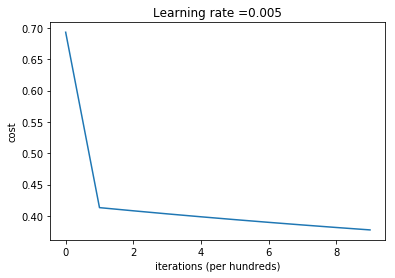

In [0]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

In [0]:
def sigmoid(z):
    A = 1.0/(1.0 + np.exp(-z))
    A = np.minimum(A, 0.9999)
    A = np.maximum(A, 0.0001)
    return A

In [0]:
def relu(z):
    A = np.maximum(0, z)
    assert(A.shape == z.shape)
    return A

In [0]:
def layer_sizes(X, Y):
    
    n_x = X.shape[0] 
    n_h = 1
    n_y = 1
    
    return (n_x, n_h, n_y)

In [0]:
def initialize_parameters(n_x, n_h, n_y):
    
    #np.random.seed(42)
    W1 = np.random.randn(n_h, n_x)
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)
    b2 = np.zeros((n_y, 1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [0]:
def forward_propagation(X, parameters):
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [0]:
def compute_cost(A2, Y, parameters):
    
    m = len(Y)
    
    cost = (-1.0/m) * np.sum(np.multiply(Y, np.log(A2)) + np.multiply((1-Y), np.log(1 - A2)))
    
    cost = float(np.squeeze(cost))
    
    assert(isinstance(cost, float))
    
    return cost

In [0]:
def backward_propagation(parameters, cache, X, Y):
    
    m = X.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    b1 = parameters["b1"]
    b2 = parameters["b2"]
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]
    Z2 = cache["Z2"]
    
    dZ2 = A2 - y_train
    dW2 = (1.0/float(m)) * np.dot(dZ2, np.transpose(A1))
    db2 = (1.0/float(m)) * np.sum(dZ2)
    dA1 = np.dot(np.transpose(W2), (A2 - y_train))
    dZ1 = np.array(dA1, copy=True)
    dZ1[Z1 <= 0] = 0
    dW1 = (1.0/float(m)) * np.dot(dZ1, X_train.T)
    db1 = (1.0/float(m)) * np.sum(dZ1)
    
    assert (dZ1.shape == Z1.shape)
    assert (dZ2.shape == Z2.shape)
    assert (dW1.shape == W1.shape)
    assert (dW2.shape == W2.shape)
    #assert (db1.shape == b1.shape)
    #assert (db2.shape == b2.shape)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [0]:
def update_parameters(parameters, grads, learning_rate = 0.05):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    b1 = parameters["b1"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    dW2 = grads["dW2"]
    db1 = grads["db1"]
    db2 = grads["db2"]
    
    W1 = W1 - (learning_rate * dW1)
    W2 = W2 - (learning_rate * dW2)
    b1 = b1 - (learning_rate * db1)
    b2 = b2 - (learning_rate * db2)
    
    parameters = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2}
    
    return parameters

In [0]:
def nn_model(X, Y, n_h, num_iterations = 10000, learning_rate = 0.05, print_cost = False):
    
   # np.random.seed(42)
    
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    for i in range(0, num_iterations):
        A2, cache = forward_propagation(X, parameters)
        
        cost = compute_cost(A2, Y, parameters)
        
        grads = backward_propagation(parameters, cache, X, Y)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [0]:
def predict(parameters, X):
    A2, cache = forward_propagation(X, parameters) 
    predictions = (A2 > 0.5)
    return predictions

In [0]:
parameters = nn_model(X_train, y_train, n_h = 333, num_iterations=3333, learning_rate = 0.333, print_cost = True)

Cost after iteration 0: 6.732797
Cost after iteration 100: 0.426296
Cost after iteration 200: 0.426287
Cost after iteration 300: 0.426287
Cost after iteration 400: 0.426287
Cost after iteration 500: 0.426287


In [0]:
np.seterr(over = 'ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'ignore', 'under': 'ignore'}

In [0]:
n_x = layer_sizes(X_train, y_train)[0]
n_y = layer_sizes(X_train, y_train)[2]
n_h = 1
learning_rate = 0.05

W1 = np.random.randn(n_h, n_x)
b1 = np.zeros((n_h, 1))
W2 = np.random.randn(n_y, n_h)
b2 = np.zeros((n_y, 1))

Z1 = np.dot(W1, X_train) + b1
A1 = relu(Z1)
Z2 = np.dot(W2, A1) + b2
A2 = sigmoid(Z2)

m = len(y_train)
cost = (-1.0/m) * np.sum(np.multiply(y_train, np.log(A2)) + np.multiply((1-y_train), np.log(1 - A2)))
cost = float(np.squeeze(cost))
cost

dZ2 = A2 - y_train
dW2 = (1.0/float(m)) * np.dot(dZ2, np.transpose(A1))
db2 = (1.0/float(m)) * np.sum(dZ2)
dA1 = np.dot(np.transpose(W2), (A2 - y_train))
dZ1 = np.array(dA1, copy=True)
dZ1[Z1 <= 0] = 0
dW1 = (1.0/float(m)) * np.dot(dZ1, X_train.T)
db1 = (1.0/float(m)) * np.sum(dZ1)

W1 = W1 - (learning_rate * dW1)
W2 = W2 - (learning_rate * dW2)
b1 = b1 - (learning_rate * db1)
b2 = b2 - (learning_rate * db2)

In [0]:
A2

array([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]])

In [0]:
X_train

array([[0.37254902, 0.35686275, 0.34117647, ..., 0.31764706, 0.48235294,
        0.39607843],
       [0.39607843, 0.36078431, 0.2745098 , ..., 0.36470588, 0.49019608,
        0.38823529],
       [0.38823529, 0.35686275, 0.28235294, ..., 0.38431373, 0.46666667,
        0.40784314],
       ...,
       [0.45490196, 0.39215686, 0.31372549, ..., 0.49803922, 0.48627451,
        0.36078431],
       [0.4627451 , 0.35294118, 0.32941176, ..., 0.56862745, 0.45882353,
        0.3372549 ],
       [0.37647059, 0.31764706, 0.35294118, ..., 0.55294118, 0.45882353,
        0.30588235]])

In [0]:
len(y_train)

8325